# Bi-LSTM for NEEL Dataset

### Author: Omer Waseem
#### Description: This Python notebook trains and evaluates a Bi-LSTM on the NEEL dataset

In [1]:
from dataprep import conll_words, neel_words
from helper import load_glove_dict, get_glove_vector, accuracy, entity_count, one_hot_encode, one_hot_decode
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, CuDNNLSTM, Bidirectional
from keras.callbacks import TensorBoard

/home/ow/miniconda3/envs/datamgt/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load all data (training and test) to create a vocabulary dictionary

In [2]:
n_train_gs_file = './datasets/NEEL2006/training_neel.gs'
n_train_tsv_file = './datasets/NEEL2006/training.tsv'
n_test_gs_file = './datasets/NEEL2006/test_neel.gs'
n_test_tsv_file = './datasets/NEEL2006/test.tsv'

n_train_words, n_train_entity, n_train_errors = neel_words(n_train_gs_file, n_train_tsv_file)
n_test_words, n_test_entity, n_test_errors = neel_words(n_test_gs_file, n_test_tsv_file)

In [3]:
combined_words = n_train_words + n_test_words

In [4]:
print(len(n_train_words))
print(len(n_test_words))
print(len(combined_words))

69390
5408
74798


### Create char set, char dictionary and find length of maximum word for padding

In [5]:
char_set = set()
char_dict = {}
max_word_len = 0
for word in combined_words:
    if len(word) > max_word_len:
        max_word_len = len(word)
    for char in word:
        char_set.add(char)

for i, char in enumerate(char_set):
    char_dict[char] = int(i) + 1 # index 0 should not be used in vocab, since its used for masking

# ensure index 0 is not used
for key in char_dict.keys():
    if char_dict[key] == 0:
        raise KeyError('Error: index 0 is used with key: ', key)

print('Maximum word length:', max_word_len)

Maximum word length: 82


### Define hyperparameters

In [6]:
max_features = len(char_set) + 1
maxlen = 90
batch_size = 128
epochs = 10
drop_out = 0.5

### Convert training and test words into padded int vectors using char dictionary

In [7]:
def word2vec(words):
    out = []
    for word in words:
        temp = []
        for char in word:
            temp.append(char_dict[char])
        out.append(temp)
    return np.array(out)

In [8]:
train_words = sequence.pad_sequences(word2vec(n_train_words), maxlen=maxlen)
test_words = sequence.pad_sequences(word2vec(n_test_words), maxlen=maxlen)

### One-Hot encode entities for training and test data

In [9]:
# one-hot formatting: [PER LOC ORG MISC O]
train_entities = one_hot_encode(n_train_entity)
test_entities = one_hot_encode(n_test_entity)

### Train Bi-LSTM model using Keras

In [10]:
model = Sequential()
model.add(Embedding(max_features, 480, input_length=maxlen))
model.add(Dropout(drop_out))
model.add(Bidirectional(CuDNNLSTM(240, return_sequences = True)))
model.add(Bidirectional(CuDNNLSTM(80)))
model.add(Dense(5, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_words, train_entities,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[test_words, test_entities],
          verbose=1)

Train on 69390 samples, validate on 5408 samples
Epoch 1/10
69390/69390 [==============================] - 32s 456us/step - loss: 0.4176 - acc: 0.8700 - val_loss: 0.4659 - val_acc: 0.8643
Epoch 2/10
69390/69390 [==============================] - 29s 418us/step - loss: 0.3562 - acc: 0.8849 - val_loss: 0.4609 - val_acc: 0.8654
Epoch 3/10
69390/69390 [==============================] - 29s 418us/step - loss: 0.3376 - acc: 0.8915 - val_loss: 0.4313 - val_acc: 0.8665
Epoch 4/10
69390/69390 [==============================] - 29s 419us/step - loss: 0.3169 - acc: 0.8989 - val_loss: 0.4460 - val_acc: 0.8499
Epoch 5/10
69390/69390 [==============================] - 29s 419us/step - loss: 0.2936 - acc: 0.9075 - val_loss: 0.4417 - val_acc: 0.8539
Epoch 6/10
69390/69390 [==============================] - 29s 421us/step - loss: 0.2694 - acc: 0.9151 - val_loss: 0.4650 - val_acc: 0.8552
Epoch 7/10
69390/69390 [==============================] - 29s 422us/step - loss: 0.2446 - acc: 0.9233 - val_loss: 0.4

### Plot accuracy and loss

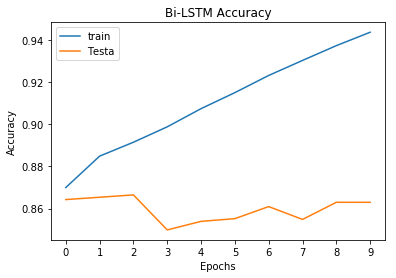

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Bi-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(epochs))
plt.legend(['train', 'Testa'], loc='upper left')
plt.show()

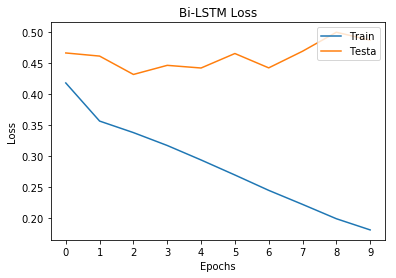

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bi-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(range(epochs))
plt.legend(['Train', 'Testa'], loc='upper right')
plt.show()

### Predict test entities using trained model

#### Evaluation for test

In [13]:
test_pred = one_hot_decode(model.predict(test_words))
accuracy(n_test_entity, test_pred)

accuracy = 4667 / 5408 = 0.862981


In [14]:
precision_recall_fscore_support(n_test_entity, test_pred)

(array([0.23728814, 0.71863118, 0.89551926, 0.37662338, 0.67811159]),
 array([0.37837838, 0.39049587, 0.98073836, 0.19863014, 0.41578947]),
 array([0.29166667, 0.5060241 , 0.9361935 , 0.26008969, 0.51549755]),
 array([  37,  484, 4361,  146,  380]))

In [15]:
entity_count(n_test_entity)

ORG: 146
PER: 380
LOC: 37
MISC: 484
O: 4361
